In [1]:
import pandas as pd
import numpy as np
from time import process_time
import pickle
from data_preprocessing import *
from devnagri_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, Bidirectional, Conv1D, Conv2D, Dropout, SpatialDropout2D, concatenate
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Attention
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


# Preparing input for word embeddings

In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [9]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index

# Preparing input for character sequences

In [32]:
def expand_concatenations(word):           
    if not re.match('[a-zA-Z]+', word) or re.match('/d+',word):
        for i in range(len(word)):
            if not('DEVANAGARI ' in unicodedata.name(word[i])):
                word = word[:i] if( len(word[i:]) < 2 and not word[i:].isnumeric()) else word[:i] + " " + word[i:]
                break
    else:
        for i in range(len(word)):
            if ('DEVANAGARI ' in unicodedata.name(word[i])):
                word = word[i:] if( len(word[:i]) < 2 and not word[:i].isnumeric() ) else word[:i] + " " + word[i:]
                break

    return(word)

In [33]:
def clean_devnagri(text: str) -> str:
    try:
        if not(isinstance(text, str)): text = str(text)

        #Removing unprintable characters
        text = ''.join(x for x in text if x.isprintable())

        # Cleaning the urls
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Cleaning the html elements
        text = re.sub(r'<.*?>', '', text)

        # Removing the punctuations
        text = re.sub('[!#?,.:";-@#$%^&*_~<>()/\-]', '', text)


        # Expanding noisy concatenations (Eg: algorithmआणि  -> algorithm आणि ) 
        text = ' '.join([expand_concatenations(word) for word in text.split()])

    except ValueError as ve:
        print('Error processing:\t',text)
        return ''
    
    return text

In [34]:
x_train_char = training_data.text.apply(lambda x: clean_devnagri(x)).values.tolist()
x_val_char = val_data.text.apply(lambda x: clean_devnagri(x)).values.tolist()
print(len(x_train_char))
print(len(x_val_char))

41997
3780


In [35]:
dp = devnagri_preprocessing()

In [36]:
char_token_dict = dp.tokenize_characters(x_train_char)
x_train_char = dp.text_to_sequence(x_train_char, char_token_dict, pad_len=400)
x_val_char = dp.text_to_sequence(x_val_char, char_token_dict, pad_len=400)
print(x_train_char.shape)
print(x_val_char.shape)

Total Unique Tokens (Characters): 799
Records converted:  41997
परंतु त्या विशिष्ट व्हॅल्यूजवर आपल्या एक्स अक्सिसवर काय प्लॉट केले आहे ते म्हणजे मी त्या ठराविक रेषेची रचना करणार्या सामग्रीची नियतकालिक संरचना दर्शवितो आणि म्हणून येथे सर्व पॅरामीटर्स आपण पाहू शकता जे दर्शवितात म्हणून त्या भौतिक संरचनासाठी तेथे एक काळिक रचना आहे जी त्या ठिपक्या रेषांद्वारे दर्शविली जाते आणि तेथे एक मुक्त इलेक्ट्रॉन पाराबोला आहे जे त्या सामग्रीमधील विद्युत् वायूंच्या वर्तनाशी संबंधित आहे
इसलिए समय के दौरान हर संगठन विकसित होता है बदलता है और कर्मचारियों के रूप में हमें वास्तव में उन परिवर्तनों का स्वागत करना चाहिए कर्मचारियों के रूप में हमें खुद को उन परिवर्तनों के अनुकूल बनाना होगा क्योंकि परिवर्तन प्रकृति का नियम है और इसलिए यह संगठनों का भी है ।
तर येथे ऊर्जा आवश्यकता काहीच नाही परंतु  mcpΔt  आहे कारण काही टप्प्यात काहीही बदल होत नाही
मग आम्ही ते टिकवून ठेवण्यासाठी आलो आहोत हे आम्हाला लगेचच बनवावे लागते जेणेकरुन कॅनस फॅलेटिज्ड केले जाऊ शकतात परंतु बहुतेकदा फ्लोर कन्व्हेयर केल्यानंतर रिक्त डिब्बे स्ट्रॉं

# Domain Specific Fasttext Embeddings

In [37]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51245
Total time taken:  5.218507184999993


(52576, 300)

In [38]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len1 = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len1)

Input dimension 1:  52576
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


In [39]:
input_len2 = x_train_char.shape[1]
print("Input Sentence dimensions 2: ", input_len2)

Input Sentence dimensions 2:  400


In [46]:
# Input 1(Domain Specific Fasttext Embeddings):
Input1 = Input(shape=(input_len1,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)
Conv1 = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(Embedding_layer1)
MaxPooling1 = MaxPooling1D(pool_size=3)(Conv1)
Dropout1 = Dropout(0.3)(MaxPooling1)
Flatten1 = Flatten()(Dropout1)

# Input 2 (Character Sequence):
Input2 = Input(shape=(input_len2,))
Dense1 = Dense(256, activation='relu')(Input2)
#Conv2 = Conv2D(filters=256, kernel_size=5,  padding='same', activation='relu')(Input2)
#MaxPooling2 = MaxPooling1D(pool_size=3)(Conv2)
Dropout2 = Dropout(0.2)(Dense1)

Merged = concatenate([Flatten1, Dropout2])
Dense2 = Dense(512, activation='relu')(Merged)
Dropout3 = Dropout(0.3)(Dense2)
Dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.015))(Dropout3)
output = Dense(4, activation='softmax')(Dense2)

classifier = Model(inputs=[Input1, Input2], outputs=output)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     15772800    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 128)     192128      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 33, 128)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

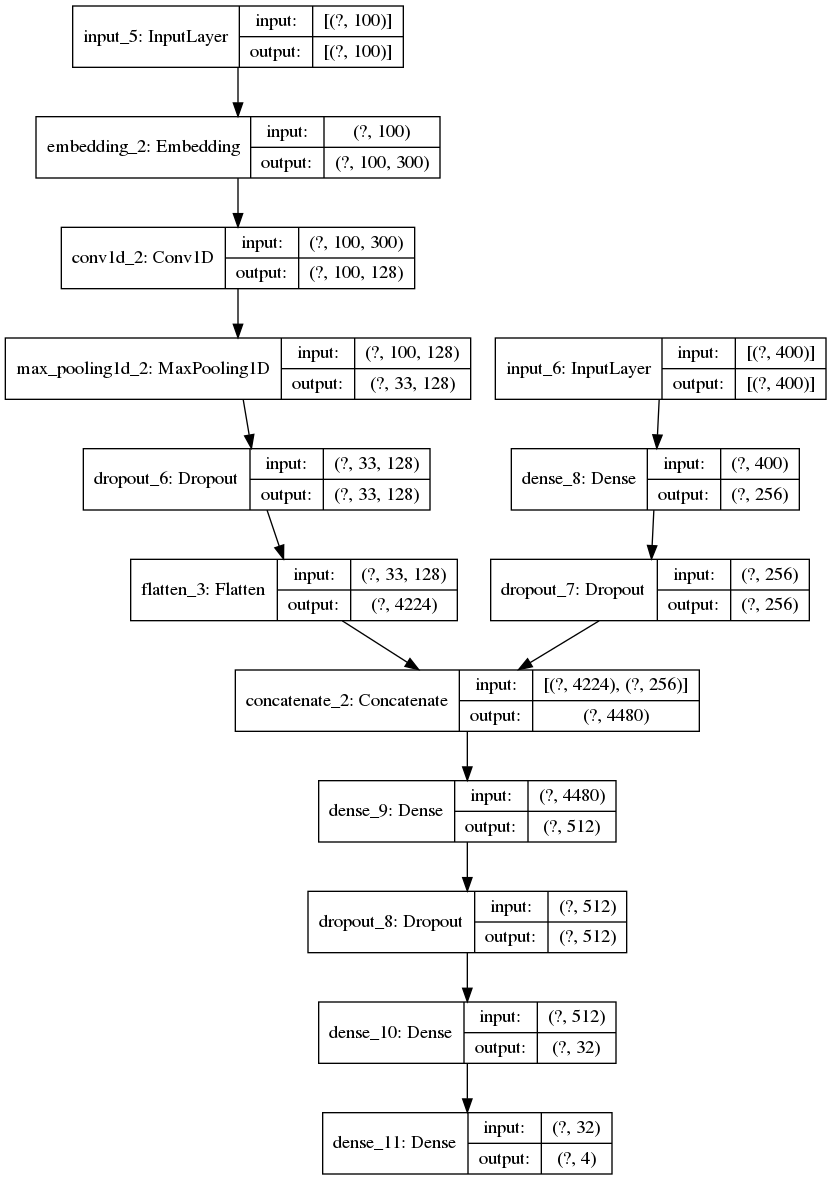

In [47]:
plot_model(classifier, show_shapes=True)

In [ ]:
history = classifier.fit([x_train_padded, x_train_char], 
                         y_train, 
                         epochs=8,
                         batch_size=128,
                         verbose=1,
                         validation_data=([x_val_padded, x_val_char], y_val))

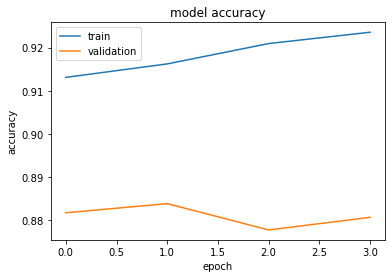

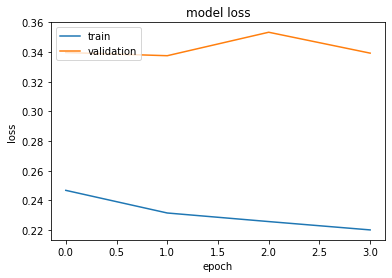

In [26]:
plot_curves(history)

In [27]:
results1 = np.argmax(classifier.predict([x_val_padded, x_val_char]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8732804232804233

Precision:  [0.90285714 0.90255376 0.90844233 0.79745686]
Average Precision:  0.8778275235648058

Recall:  [0.75238095 0.8923588  0.86327684 0.90515464]
Average Recall:  0.8532928079252783

F1-Score:  [0.82077922 0.89742733 0.88528389 0.84789957]
Average F1-Score:  0.862847502509843
